# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [2]:
# import libraries
from pyspark.sql.types import StringType, DateType, IntegerType, TimestampType
from pyspark.sql import functions as F, window
from itertools import chain
import re
import h2o
import matplotlib.pyplot as plt

In [3]:
# create a Spark session
from pysparkling import H2OContext
hc = H2OContext.getOrCreate(spark)

Connecting to H2O server at http://10.139.64.44:54321... successful.
-------------------------- ---------------------------------------------------
H2O cluster uptime: 07 secs
H2O cluster timezone: Etc/UTC
H2O data parsing timezone: UTC
H2O cluster version: 3.22.1.5
H2O cluster version age: 3 months and 15 days !!!
H2O cluster name: sparkling-water-root_app-20190620182734-0000
H2O cluster total nodes: 2
H2O cluster free memory: 169.9 Gb
H2O cluster total cores: 64
H2O cluster allowed cores: 64
H2O cluster status: accepting new members, healthy
H2O connection url: http://10.139.64.44:54321
H2O connection proxy:
H2O internal security: False
H2O API Extensions: XGBoost, Algos, Amazon S3, AutoML, Core V3, Core V4
Python version: 2.7.12 final
-------------------------- ---------------------------------------------------

Sparkling Water Context:
 * H2O name: sparkling-water-root_app-20190620182734-0000
 * cluster size: 2
 * list of used nodes:
 (executorId, host, port)
 ------------------------
 (1,10.139.64.41,54321)
 (0,10.139.64.54,54321)
 ------------------------

 Open H2O Flow in browser: http://10.139.64.44:54321 (CMD + click in Mac OSX)

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids.

In [5]:
df = spark.read.json('medium-sparkify-event-data.json')
display(df)

artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
Martin Orford,Logged In,Joseph,M,20,Morales,597.55057,free,"Corpus Christi, TX",PUT,NextSong,1532063507000,292,Grand Designs,200,1538352011000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36""",293
John Brown's Body,Logged In,Sawyer,M,74,Larson,380.21179,free,"Houston-The Woodlands-Sugar Land, TX",PUT,NextSong,1538069638000,97,Bulls,200,1538352025000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",98
Afroman,Logged In,Maverick,M,184,Santiago,202.37016,paid,"Orlando-Kissimmee-Sanford, FL",PUT,NextSong,1535953455000,178,Because I Got High,200,1538352118000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",179
null,Logged In,Maverick,M,185,Santiago,null,paid,"Orlando-Kissimmee-Sanford, FL",PUT,Logout,1535953455000,178,null,307,1538352119000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",179
Lily Allen,Logged In,Gianna,F,22,Campos,194.53342,paid,"Mobile, AL",PUT,NextSong,1535931018000,245,Smile (Radio Edit),200,1538352124000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,246
Carter USM,Logged In,Sofia,F,266,Gordon,138.29179,paid,"Rochester, MN",PUT,NextSong,1533175710000,162,Airplane Food,200,1538352125000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.94 Safari/537.36""",163
null,Logged Out,null,null,186,null,null,paid,null,GET,Home,null,178,null,200,1538352148000,null,
null,Logged Out,null,null,187,null,null,paid,null,GET,Home,null,178,null,200,1538352151000,null,
null,Logged Out,null,null,188,null,null,paid,null,GET,Home,null,178,null,200,1538352168000,null,
null,Logged Out,null,null,189,null,null,paid,null,PUT,Login,null,178,null,307,1538352169000,null,


## Turn ts column into correct timestamp

In [7]:
df = df\
  .withColumn('ts',F.to_timestamp(F.col('ts')/1000))
display(df.select('ts').limit(5))

ts
2018-10-01T00:00:11.000+0000
2018-10-01T00:00:25.000+0000
2018-10-01T00:01:58.000+0000
2018-10-01T00:01:59.000+0000
2018-10-01T00:02:04.000+0000


## Check null or empty values

In [9]:
# Check number of nulls in each column
display(df.select([F.count(F.when(F.col(c).isNull(), F.col(c))).alias(c) for c in df.columns]))

artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
df.count()

Out[ 6 ]: 543705

In [11]:
# Remove empty userId
df = df.filter(F.col('userId')!='')
df.count()

Out[ 7 ]: 528005

In [12]:
# Check validity of sessionId
display(df.select('sessionId').describe())

summary,sessionId
count,528005
mean,2042.9801820058522
stddev,1433.998148941064
min,1
max,4808


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

## Explore 'Cancellation Confirmation'

In [15]:
# Get the count of different page information
display(df.groupBy("page").count())

page,count
Cancel,99
Submit Downgrade,117
Thumbs Down,4911
Home,19089
Downgrade,3811
Roll Advert,7773
Logout,5990
Save Settings,585
Cancellation Confirmation,99
About,1026


In [16]:
# Get the cancelled customer list
df.filter(F.col('page')=='Cancellation Confirmation').select('userId').distinct().show(5)

+------+
userId|
+------+
 296|
100010|
200002|
 51|
 124|
+------+
only showing top 5 rows

In [17]:
# Check one customer's journey
display(df.filter(F.col('userId')==296).sort('ts'))

artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
Atomic Kitten,Logged In,Angelynn,F,0,Coffey,217.46893,free,"Allentown-Bethlehem-Easton, PA-NJ",PUT,NextSong,1536885688000,463,Right Now (Radio Edit),200,2018-10-02T10:55:51.000+0000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.78.2 (KHTML, like Gecko) Version/7.0.6 Safari/537.78.2""",296
MFSB,Logged In,Angelynn,F,1,Coffey,432.79628,free,"Allentown-Bethlehem-Easton, PA-NJ",PUT,NextSong,1536885688000,463,Freddie's Dead,200,2018-10-02T10:59:28.000+0000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.78.2 (KHTML, like Gecko) Version/7.0.6 Safari/537.78.2""",296
Little River Band,Logged In,Angelynn,F,2,Coffey,347.42812,free,"Allentown-Bethlehem-Easton, PA-NJ",PUT,NextSong,1536885688000,463,Lonesome Loser,200,2018-10-02T11:06:40.000+0000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.78.2 (KHTML, like Gecko) Version/7.0.6 Safari/537.78.2""",296
Orishas,Logged In,Angelynn,F,0,Coffey,239.41179,free,"Allentown-Bethlehem-Easton, PA-NJ",PUT,NextSong,1536885688000,631,Elegante,200,2018-10-03T08:56:43.000+0000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.78.2 (KHTML, like Gecko) Version/7.0.6 Safari/537.78.2""",296
Jamie Foxx featuring Justin Timberlake & T.I.,Logged In,Angelynn,F,1,Coffey,244.34893,free,"Allentown-Bethlehem-Easton, PA-NJ",PUT,NextSong,1536885688000,631,Winner,200,2018-10-03T09:00:42.000+0000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.78.2 (KHTML, like Gecko) Version/7.0.6 Safari/537.78.2""",296
A Fine Frenzy,Logged In,Angelynn,F,2,Coffey,252.26404,free,"Allentown-Bethlehem-Easton, PA-NJ",PUT,NextSong,1536885688000,631,Last Of Days,200,2018-10-03T09:04:46.000+0000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.78.2 (KHTML, like Gecko) Version/7.0.6 Safari/537.78.2""",296
Saybia,Logged In,Angelynn,F,3,Coffey,270.34077,free,"Allentown-Bethlehem-Easton, PA-NJ",PUT,NextSong,1536885688000,631,Angel,200,2018-10-03T09:08:58.000+0000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.78.2 (KHTML, like Gecko) Version/7.0.6 Safari/537.78.2""",296
Carla Bruni,Logged In,Angelynn,F,4,Coffey,183.58812,free,"Allentown-Bethlehem-Easton, PA-NJ",PUT,NextSong,1536885688000,631,L'Excessive,200,2018-10-03T09:13:28.000+0000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.78.2 (KHTML, like Gecko) Version/7.0.6 Safari/537.78.2""",296
Melody Gardot,Logged In,Angelynn,F,5,Coffey,210.6771,free,"Allentown-Bethlehem-Easton, PA-NJ",PUT,NextSong,1536885688000,631,Baby I'm A Fool,200,2018-10-03T09:16:31.000+0000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.78.2 (KHTML, like Gecko) Version/7.0.6 Safari/537.78.2""",296
David Gray,Logged In,Angelynn,F,6,Coffey,362.00444,free,"Allentown-Bethlehem-Easton, PA-NJ",PUT,NextSong,1536885688000,631,Silver Lining,200,2018-10-03T09:20:01.000+0000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.78.2 (KHTML, like Gecko) Version/7.0.6 Safari/537.78.2""",296


## Define Churn

In [19]:
wf_user = window.Window().partitionBy('userId')

In [20]:
df_with_churn = df\
  .withColumn('Cancel',(F.col('page')=="Cancellation Confirmation").astype(IntegerType()))\
  .withColumn('Cancel_flag',F.sum(F.col('Cancel')).over(wf_user))\
  .withColumn('Churn', F.when(F.col('Cancel_flag')>=1,1).otherwise(0))

In [21]:
# churn distribution of users:
display(df_with_churn\
  .select('userId','Churn').distinct()\
  .groupBy('Churn')\
  .count())

Churn,count
1,99
0,349


# Exploratory Analysis on Churn

In [23]:
# Stacked bar chart of churn rate between gender
display(df_with_churn.select('gender','userId','Churn').distinct().groupBy('gender','Churn').count())

gender,Churn,count
M,1,54
F,0,153
F,1,45
M,0,196


In [24]:
# Mean of number of operations between churn and non-churn group 
display(df_with_churn\
  .groupBy('userId','Churn')\
  .agg(F.count('*'))\
  .groupBy('Churn')\
  .agg(F.mean('count(1)').alias('mean_operation')))

Churn,mean_operation
1,1046.9292929292928
0,1215.9283667621776


In [25]:
# Mean of song length between churn and non-churn group 
display(df_with_churn\
  .groupBy('userId','Churn')\
  .agg(F.mean('length'))\
  .groupBy('Churn')\
  .agg(F.mean('avg(length)').alias('mean_length')))

Churn,mean_length
1,248.40508290950058
0,248.14949934740648


In [26]:
# Stacked bar chart of churn rate between user has ever been paid user or not
display(df_with_churn\
  .withColumn('level_list',F.collect_set(F.col('level')).over(wf_user))\
  .withColumn('ever_paid',F.udf(lambda x: int('paid' in x), IntegerType())('level_list'))\
  .select('userId','Churn','ever_paid').distinct()\
  .groupBy('ever_paid','Churn').count())

ever_paid,Churn,count
1,0,246
1,1,75
0,0,103
0,1,24


In [27]:
# Region map
regions = {
  "NEW_ENGLAND": ['CT','ME','MA','NH','RI','VT'],
  'MID_ATLANTIC': ['NJ','NY','PA'],
  'EAST_NORTH_CENTRAL': ['IN','IL','MI','OH','WI'],
  'WEST_NORTH_CENTRAL': ['IA','KS','MN','MO','NE','ND','SD'],
  'SOUTH_ATLANTIC': ['DE','DC','FL','GA','MD','NC','SC','VA','WV'],
  'EAST_SOUTH_CENTRAL': ['AL','KY','MS','TN','AR','LA','OK','TX'],
  'MOUNTAIN': ['AZ','CO','ID','NM','MT','UT','NV','WY'],
  'PACIFIC': ['AK','CA','HI','OR','WA']}
regions = {i: k for k, v in regions.items() for i in v }

In [28]:
# Stacked bar chart of churn rate between different regions 
display(df_with_churn\
  .withColumn('state',F.split(F.col('location'),',')[1])\
  .withColumn('state',F.split(F.col('state'),'-')[0])\
  .withColumn('region',F.udf(lambda x: regions[x.strip()], StringType())('state'))\
  .groupBy('region','Churn')\
  .count())

region,Churn,count
SOUTH_ATLANTIC,0,86758
EAST_SOUTH_CENTRAL,1,25749
MID_ATLANTIC,1,20835
NEW_ENGLAND,0,27832
SOUTH_ATLANTIC,1,16593
MOUNTAIN,0,33137
WEST_NORTH_CENTRAL,0,30398
PACIFIC,1,14412
EAST_NORTH_CENTRAL,1,10980
WEST_NORTH_CENTRAL,1,5711


In [29]:
# Mean of PUT percentage between churn and non-churn group 
display(df_with_churn\
  .withColumn('n_operation',F.count('*').over(wf_user))\
  .withColumn('n_PUT',F.sum(F.when(F.col('method')=='PUT',1).otherwise(0)).over(wf_user))\
  .withColumn('PUT_perc',F.col('n_PUT')/F.col('n_operation'))\
  .select('userId','Churn','PUT_perc')\
  .groupBy('Churn')\
  .agg(F.min('PUT_perc').alias('mean_PUT_percentage')))

Churn,mean_PUT_percentage
1,0.6153846153846154
0,0.6666666666666666


In [30]:
# Stacked bar chart of churn rate between different platforms 
display(df_with_churn\
    .withColumn('platform',F.udf(lambda x: re.search(r'Macintosh|Windows|Linux|iPhone|iPad',x).group(0))('userAgent'))\
    .select('userId','Churn','platform').distinct()\
    .groupBy('Churn','platform')\
    .count())

Churn,platform,count
1,Macintosh,35
0,iPad,9
1,Linux,5
0,iPhone,7
0,Linux,21
1,iPhone,11
1,Windows,48
0,Windows,174
0,Macintosh,138


In [31]:
# Mean of tenure days between churn and non-churn group
display(df_with_churn\
    .withColumn('ft_tenure_days',F.datediff(F.max('ts').over(wf_user).cast(DateType()),F.min('ts').over(wf_user).cast(DateType())))\
    .select('userId','Churn','ft_tenure_days').distinct()\
    .groupBy('Churn')\
    .agg(F.mean('ft_tenure_days')))

Churn,avg(ft_tenure_days)
1,25.32323232323232
0,45.98567335243553


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [33]:
wf_session = window.Window().partitionBy('userId','sessionId')

In [34]:
predictor_columns = ['ft_gender','ft_n_operation','ft_n_session','ft_operation_per_session','ft_mean_length',
                     'ft_ever_paid','ft_region','ft_PUT_perc','ft_platform','ft_tenure_days','ft_avg_time_per_session',
                     'ft_min_time_per_session','ft_max_time_per_session','ft_n_songs','ft_mean_song_per_session']

response_column =  'Churn'

Feature definition:  
- ft_gender: raw gender column from data
- ft_n_operation: count of rows per user
- ft_n_session: count of distinct sessionId per user
- ft_operation_per_session: ft_n_operation over ft_n_session
- ft_mean_length: average length of the song per user
- ft_ever_paid: user ever has ‘paid’ in his level column
- ft_region: user location extracts out state, then map to region
- ft_PUT_perc: percentage of PUT request over all operation per user
- ft_platform: extract device platform information from userAgent column
- ft_tenure_days: date difference between max and min ts of a user
- ft_avg_time_per_session: average of second difference between max and min ts of all sessions for a user
- ft_min_time_per_session: min of second difference between max and min ts of all sessions for a user
- ft_max_time_per_session: max of second difference between max and min ts of all sessions for a user
- ft_n_songs: number of distinct songs one user has listened
- ft_mean_song_per_session: average of number of distinct songs in all sessions of one user

In [36]:
df_with_churn_feature = df_with_churn\
  .withColumnRenamed('gender','ft_gender')\
  .withColumn('ft_n_operation',F.count('*').over(wf_user))\
  .withColumn('ft_n_session',F.size(F.collect_set(F.col('sessionId')).over(wf_user)))\
  .withColumn('ft_operation_per_session',F.col('ft_n_operation')/F.col('ft_n_session'))\
  .withColumn('ft_mean_length',F.mean('length').over(wf_user))\
  .withColumn('level_list',F.collect_set(F.col('level')).over(wf_user))\
  .withColumn('ft_ever_paid',F.udf(lambda x: int('paid' in x), IntegerType())('level_list'))\
  .withColumn('state',F.split(F.col('location'),',')[1])\
  .withColumn('state',F.split(F.col('state'),'-')[0])\
  .withColumn('ft_region',F.udf(lambda x: regions[x.strip()], StringType())('state'))\
  .withColumn('n_PUT',F.sum(F.when(F.col('method')=='PUT',1).otherwise(0)).over(wf_user))\
  .withColumn('ft_PUT_perc',F.col('n_PUT')/F.col('ft_n_operation'))\
  .withColumn('ft_platform',F.udf(lambda x: re.search(r'Macintosh|Windows|Linux|iPhone|iPad',x).group(0))('userAgent'))\
  .withColumn('ft_tenure_days',F.datediff(F.max('ts').over(wf_user).cast(DateType()),F.min('ts').over(wf_user).cast(DateType())))\
  .withColumn('time_per_session',F.unix_timestamp(F.max('ts').over(wf_session)) - F.unix_timestamp(F.min('ts').over(wf_session)))\
  .withColumn('ft_avg_time_per_session',F.mean('time_per_session').over(wf_user))\
  .withColumn('ft_min_time_per_session',F.min('time_per_session').over(wf_user))\
  .withColumn('ft_max_time_per_session',F.max('time_per_session').over(wf_user))\
  .withColumn('ft_n_songs',F.size(F.collect_set(F.col('song')).over(wf_user)))\
  .withColumn('song_per_session',F.size(F.collect_set(F.col('song')).over(wf_session)))\
  .withColumn('ft_mean_song_per_session',F.mean('song_per_session').over(wf_user))\
  .select(*(['userId'] + predictor_columns + ['Churn'])).distinct()

In [37]:
# Save the feature set
df_with_churn_feature.write.parquet('df_with_churn_feature','overwrite')

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [39]:
# Read in the feature set
df_with_churn_feature = spark.read.parquet('df_with_churn_feature')

In [40]:
display(df_with_churn_feature)

userId,ft_gender,ft_n_operation,ft_n_session,ft_operation_per_session,ft_mean_length,ft_ever_paid,ft_region,ft_PUT_perc,ft_platform,ft_tenure_days,ft_avg_time_per_session,ft_min_time_per_session,ft_max_time_per_session,ft_n_songs,ft_mean_song_per_session,Churn
100012,M,167,6,27.833333333333332,242.2323166071428,0,EAST_NORTH_CENTRAL,0.7604790419161677,Macintosh,31,7959.377245508982,0,9923,112,33.7185628742515,1
100034,F,191,2,95.5,235.85976389221557,1,MOUNTAIN,0.9528795811518325,Macintosh,26,24036.84293193717,9707,29257,159,99.17277486910994,0
100044,M,186,4,46.5,237.6077594696969,0,MID_ATLANTIC,0.7795698924731183,Macintosh,2,9514.537634408602,2185,11778,132,41.575268817204304,1
150,M,196,4,49.0,251.07251567741943,0,MOUNTAIN,0.8877551020408163,Macintosh,51,17376.64285714286,1378,24662,150,58.275510204081634,0
200018,M,1329,18,73.83333333333333,245.29124418582327,1,MID_ATLANTIC,0.90744920993228,iPhone,55,23961.843491346877,10,49959,970,98.03611738148985,0
200031,M,42,1,42.0,243.64169259259256,0,EAST_NORTH_CENTRAL,0.8095238095238095,Windows,0,6319.0,6319,6319,27,27.0,0
269,F,3511,34,103.26470588235294,245.23145883103402,1,EAST_NORTH_CENTRAL,0.9327826829962973,Windows,56,60364.24551409855,0,125194,2450,224.30048419253774,0
277,F,126,3,42.0,251.75167475247537,0,MID_ATLANTIC,0.8888888888888888,Windows,49,21246.968253968254,530,24839,101,73.96825396825396,0
100004,F,373,5,74.6,249.09314980916034,0,MID_ATLANTIC,0.8123324396782842,Windows,11,18847.69436997319,2911,26685,256,73.11796246648794,1
104,F,2950,26,113.46153846153847,247.95266878812194,1,MOUNTAIN,0.9420338983050848,Windows,56,60450.87559322034,0,109238,2174,237.91423728813558,0


In [41]:
# Train=validation-test split
df_train, df_valid, df_test = df_with_churn_feature.randomSplit([0.6, 0.2, 0.2])

In [42]:
# Turn Spark dataframe into h2o frame
df_trainHF = hc.as_h2o_frame(df_train, "df_train")
df_validHF = hc.as_h2o_frame(df_valid, "df_valid")
df_testHF = hc.as_h2o_frame(df_test, "df_test")

In [43]:
# Transform selected String columns to categoricals
cat_cols = ['ft_gender','ft_region','ft_platform',response_column]

for col in cat_cols :
    df_trainHF[col] = df_trainHF[col].asfactor()
    df_validHF[col] = df_validHF[col].asfactor()
    df_testHF[col] = df_testHF[col].asfactor()

In [44]:
# Create and train GBM model
from h2o.estimators import H2OXGBoostEstimator

# Prepare model based on the given set of parameters
xgb_model = H2OXGBoostEstimator(ntrees = 15,
                                tree_method = "hist",
                                grow_policy = "lossguide",
                                distribution = "bernoulli")

# Train the model
xgb_model.train(x = predictor_columns,
                y = response_column,
                training_frame = df_trainHF,
                validation_frame = df_validHF)

xgboost Model Build progress: [###########################################] 100%

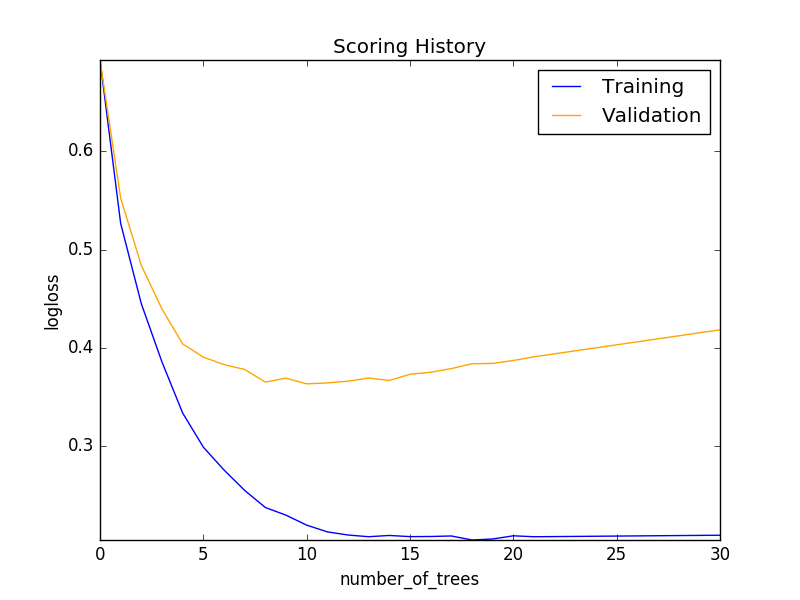

In [45]:
display(xgb_model.plot())
plt.close()

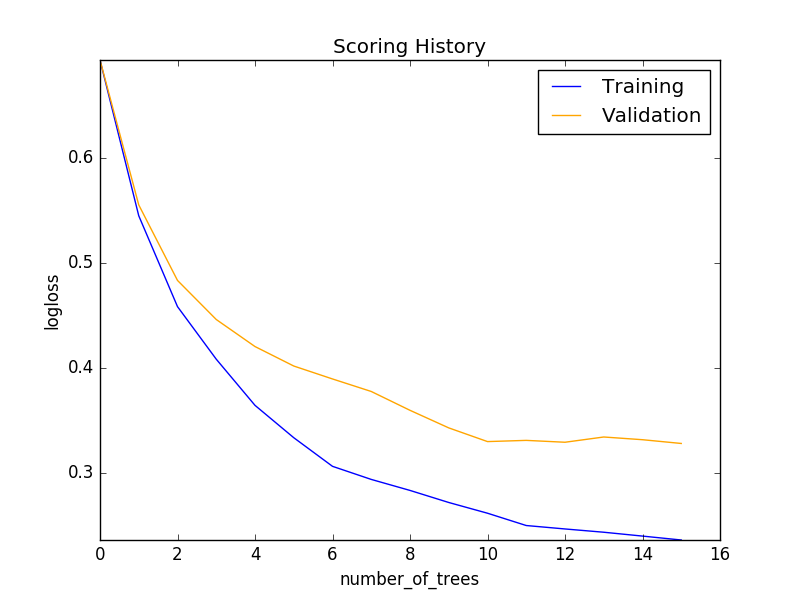

In [46]:
display(xgb_model.plot())
plt.close()

In [47]:
# Show GBM model performance
perf = xgb_model.model_performance(df_trainHF)
perf

Out[ 14 ]: 
ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.0536411492036
RMSE: 0.23160558975
LogLoss: 0.207793416391
Mean Per-Class Error: 0.107352941176
AUC: 0.93779956427
pr_auc: 0.844298685432
Gini: 0.87559912854
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.404286473989: 
 0 1 Error Rate
----- --- --- ------- ------------
0 201 3 0.0147 (3.0/204.0)
1 9 36 0.2 (9.0/45.0)
Total 210 39 0.0482 (12.0/249.0)
Maximum Metrics: Maximum metrics at their respective thresholds

metric threshold value idx
--------------------------- ----------- -------- -----
max f1 0.404286 0.857143 38
max f2 0.300385 0.822222 43
max f0point5 0.404286 0.895522 38
max accuracy 0.404286 0.951807 38
max precision 0.967038 1 0
max recall 0.0172782 1 134
max specificity 0.967038 1 0
max absolute_mcc 0.404286 0.831403 38
max min_per_class_accuracy 0.154642 0.866667 59
max mean_per_class_accuracy 0.404286 0.892647 38
Gains/Lift Table: Avg response rate: 18.07 %, avg score: 16.71 %

 group cumulative_data_fraction lower_threshold lift cumulative_lift response_rate score cumulative_response_rate cumulative_score capture_rate cumulative_capture_rate gain cumulative_gain
-- ------- -------------------------- ----------------- -------- ----------------- --------------- --------- -------------------------- ------------------ -------------- ------------------------- -------- -----------------
 1 0.0120482 0.924833 5.53333 5.53333 1 0.944062 1 0.944062 0.0666667 0.0666667 453.333 453.333
 2 0.0200803 0.915053 5.53333 5.53333 1 0.917037 1 0.933252 0.0444444 0.111111 453.333 453.333
 3 0.0321285 0.899665 5.53333 5.53333 1 0.907505 1 0.923597 0.0666667 0.177778 453.333 453.333
 4 0.0401606 0.887846 5.53333 5.53333 1 0.894893 1 0.917856 0.0444444 0.222222 453.333 453.333
 5 0.0522088 0.865735 5.53333 5.53333 1 0.882086 1 0.909601 0.0666667 0.288889 453.333 453.333
 6 0.100402 0.757066 5.07222 5.312 0.916667 0.798265 0.96 0.85616 0.244444 0.533333 407.222 431.2
 7 0.15261 0.411165 4.68205 5.09649 0.846154 0.594244 0.921053 0.766557 0.244444 0.777778 368.205 409.649
 8 0.200803 0.22839 0.922222 4.09467 0.166667 0.311291 0.74 0.657293 0.0444444 0.822222 -7.77778 309.467
 9 0.301205 0.115381 0.664 2.95111 0.12 0.165112 0.533333 0.493233 0.0666667 0.888889 -33.6 195.111
 10 0.401606 0.0417451 0 2.21333 0 0.0708341 0.4 0.387633 0 0.888889 -100 121.333
 11 0.506024 0.0252153 0.638462 1.88836 0.115385 0.0308174 0.34127 0.314005 0.0666667 0.955556 -36.1538 88.836
 12 0.598394 0.0198974 0.24058 1.634 0.0434783 0.0220383 0.295302 0.268936 0.0222222 0.977778 -75.942 63.4004
 13 0.698795 0.0173671 0 1.39923 0 0.0185519 0.252874 0.232961 0 0.977778 -100 39.9234
 14 0.807229 0.015261 0.204938 1.23881 0.037037 0.0161428 0.223881 0.203836 0.0222222 1 -79.5062 23.8806
 15 0.899598 0.0129157 0 1.11161 0 0.0143867 0.200893 0.184384 0 1 -100 11.1607
 16 1 0.0121967 0 1 0 0.0122125 0.180723 0.167098 0 1 -100 0

In [48]:
# Show GBM model performance
perf = xgb_model.model_performance(df_validHF)
perf

Out[ 15 ]: 
ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.112555119932
RMSE: 0.335492354506
LogLoss: 0.373132456876
Mean Per-Class Error: 0.158064516129
AUC: 0.890322580645
pr_auc: 0.746095343716
Gini: 0.78064516129
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.289631694555: 
 0 1 Error Rate
----- --- --- ------- ----------
0 61 1 0.0161 (1.0/62.0)
1 6 14 0.3 (6.0/20.0)
Total 67 15 0.0854 (7.0/82.0)
Maximum Metrics: Maximum metrics at their respective thresholds

metric threshold value idx
--------------------------- ----------- -------- -----
max f1 0.289632 0.8 14
max f2 0.0850274 0.79646 31
max f0point5 0.289632 0.875 14
max accuracy 0.289632 0.914634 14
max precision 0.861407 1 0
max recall 0.0157497 1 65
max specificity 0.861407 1 0
max absolute_mcc 0.289632 0.75963 14
max min_per_class_accuracy 0.103476 0.8 26
max mean_per_class_accuracy 0.289632 0.841935 14
Gains/Lift Table: Avg response rate: 24.39 %, avg score: 15.19 %

 group cumulative_data_fraction lower_threshold lift cumulative_lift response_rate score cumulative_response_rate cumulative_score capture_rate cumulative_capture_rate gain cumulative_gain
-- ------- -------------------------- ----------------- ------ ----------------- --------------- --------- -------------------------- ------------------ -------------- ------------------------- ------ -----------------
 1 0.0121951 0.85691 4.1 4.1 1 0.861407 1 0.861407 0.05 0.05 310 310
 2 0.0243902 0.817334 4.1 4.1 1 0.855856 1 0.858631 0.05 0.1 310 310
 3 0.0365854 0.757371 4.1 4.1 1 0.793724 1 0.836996 0.05 0.15 310 310
 4 0.0487805 0.702775 4.1 4.1 1 0.709181 1 0.805042 0.05 0.2 310 310
 5 0.0609756 0.68232 0 3.28 0 0.682489 0.8 0.780531 0 0.2 -100 228
 6 0.109756 0.491734 4.1 3.64444 1 0.54487 0.888889 0.675793 0.2 0.4 310 264.444
 7 0.158537 0.400099 4.1 3.78462 1 0.429674 0.923077 0.600064 0.2 0.6 310 278.462
 8 0.207317 0.259254 2.05 3.37647 0.5 0.300395 0.823529 0.529554 0.1 0.7 105 237.647
 9 0.304878 0.11914 0.5125 2.46 0.125 0.187728 0.6 0.420169 0.05 0.75 -48.75 146
 10 0.402439 0.0794847 1.5375 2.23636 0.375 0.0960308 0.545455 0.34159 0.15 0.9 53.75 123.636
 11 0.5 0.0349575 0 1.8 0 0.050223 0.439024 0.284738 0 0.9 -100 80
 12 0.597561 0.0251419 0 1.50612 0 0.029316 0.367347 0.243037 0 0.9 -100 50.6122
 13 0.695122 0.018995 0.5125 1.36667 0.125 0.0227246 0.333333 0.212116 0.05 0.95 -48.75 36.6667
 14 0.792683 0.0159347 0 1.19846 0 0.0177996 0.292308 0.1882 0 0.95 -100 19.8462
 15 0.890244 0.0123474 0.5125 1.12329 0.125 0.0145547 0.273973 0.16917 0.05 1 -48.75 12.3288
 16 1 0.0121967 0 1 0 0.0122406 0.243902 0.151946 0 1 -100 0

In [49]:
# Show GBM model performance
perf = xgb_model.model_performance(df_testHF)
perf

Out[ 20 ]: 
ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.150676454024
RMSE: 0.388170650647
LogLoss: 0.508400826745
Mean Per-Class Error: 0.206591070163
AUC: 0.843373493976
pr_auc: 0.708606347074
Gini: 0.686746987952
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.284287422895: 
 0 1 Error Rate
----- --- --- ------- ------------
0 78 5 0.0602 (5.0/83.0)
1 12 22 0.3529 (12.0/34.0)
Total 90 27 0.1453 (17.0/117.0)
Maximum Metrics: Maximum metrics at their respective thresholds

metric threshold value idx
--------------------------- ----------- -------- -----
max f1 0.284287 0.721311 23
max f2 0.0300584 0.765306 55
max f0point5 0.295034 0.783582 21
max accuracy 0.295034 0.854701 21
max precision 0.961655 1 0
max recall 0.0121967 1 88
max specificity 0.961655 1 0
max absolute_mcc 0.284287 0.632381 23
max min_per_class_accuracy 0.0926794 0.764706 37
max mean_per_class_accuracy 0.284287 0.793409 23
Gains/Lift Table: Avg response rate: 29.06 %, avg score: 16.94 %

 group cumulative_data_fraction lower_threshold lift cumulative_lift response_rate score cumulative_response_rate cumulative_score capture_rate cumulative_capture_rate gain cumulative_gain
-- ------- -------------------------- ----------------- -------- ----------------- --------------- --------- -------------------------- ------------------ -------------- ------------------------- -------- -----------------
 1 0.017094 0.948783 3.44118 3.44118 1 0.956052 1 0.956052 0.0588235 0.0588235 244.118 244.118
 2 0.025641 0.936908 3.44118 3.44118 1 0.940031 1 0.950712 0.0294118 0.0882353 244.118 244.118
 3 0.034188 0.903386 3.44118 3.44118 1 0.930272 1 0.945602 0.0294118 0.117647 244.118 244.118
 4 0.042735 0.822717 0 2.75294 0 0.87426 0.8 0.931333 0 0.117647 -100 175.294
 5 0.0512821 0.770591 3.44118 2.86765 1 0.793724 0.833333 0.908398 0.0294118 0.147059 244.118 186.765
 6 0.102564 0.55757 2.29412 2.58088 0.666667 0.70991 0.75 0.809154 0.117647 0.264706 129.412 158.088
 7 0.162393 0.412885 3.44118 2.89783 1 0.47175 0.842105 0.684847 0.205882 0.470588 244.118 189.783
 8 0.213675 0.295034 2.86765 2.89059 0.833333 0.346846 0.84 0.603727 0.147059 0.617647 186.765 189.059
 9 0.299145 0.139216 1.03235 2.35966 0.3 0.200814 0.685714 0.488609 0.0882353 0.705882 3.23529 135.966
 10 0.401709 0.0617682 0.573529 1.90363 0.166667 0.0947588 0.553191 0.388051 0.0588235 0.764706 -42.6471 90.363
 11 0.504274 0.0322705 0.860294 1.69143 0.25 0.0436322 0.491525 0.318 0.0882353 0.852941 -13.9706 69.1426
 12 0.598291 0.0225556 0.625668 1.52395 0.181818 0.0259691 0.442857 0.272109 0.0588235 0.911765 -37.4332 52.395
 13 0.700855 0.019221 0 1.30093 0 0.020948 0.378049 0.235354 0 0.911765 -100 30.0933
 14 0.794872 0.0163903 0.312834 1.18406 0.0909091 0.0178641 0.344086 0.20963 0.0294118 0.941176 -68.7166 18.4061
 15 0.905983 0.0144078 0 1.03885 0 0.0149279 0.301887 0.185751 0 0.941176 -100 3.88457
 16 1 0.0121967 0.625668 1 0.181818 0.0123632 0.290598 0.16945 0.0588235 1 -37.4332 0

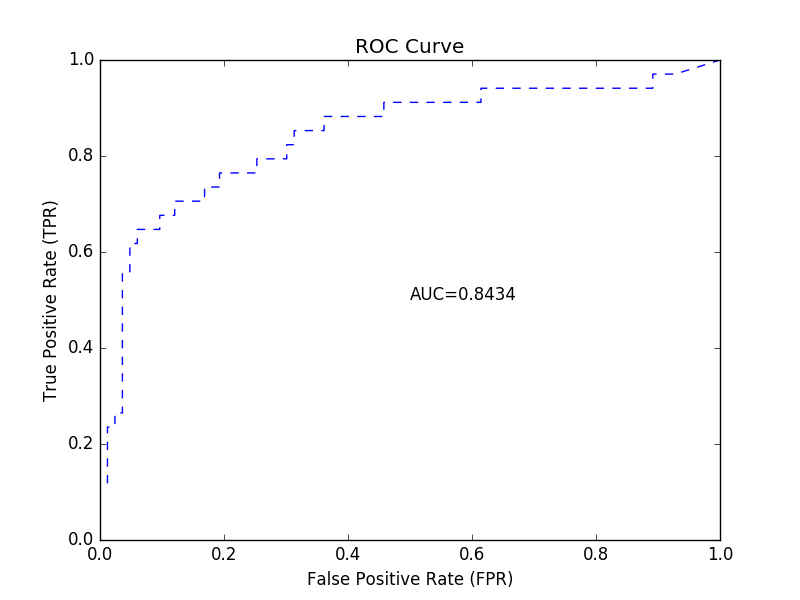

In [50]:
display(perf.plot())

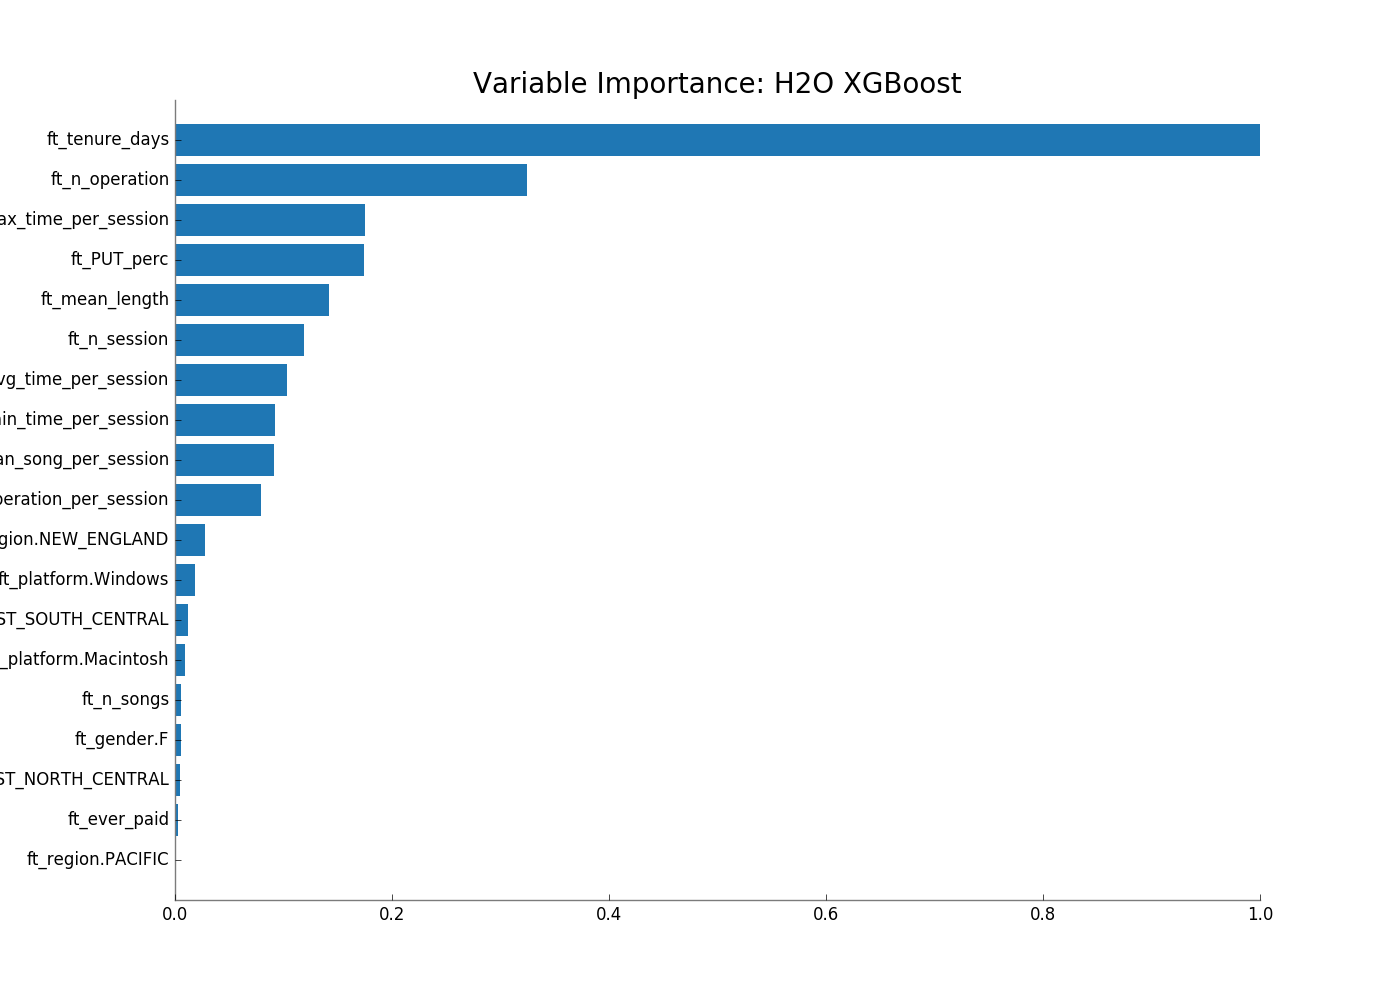

In [51]:
display(xgb_model.varimp_plot(1000))
plt.close()

In [52]:
xgb_model.varimp_plot(1000)
plt.savefig('varimp_plot.png',bbox_inches='tight')
plt.close()

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.